# GridWorld 3:

*GridWorld* es un mundo en forma de cuadrícula muy utilizado como entorno de pruebas para técnicas de Aprendizaje por Refuerzo. Dentro de esta cuadrícula hay varios tipos de celdas: iniciales, libres, obstáculos, terminales... ¡y ahora también catapultas y agujeros de gusano! Los agentes tienen que llegar desde una celda inicial hasta otra terminal evitando los obtáculos y recorriendo una distancia mínima.

Paquetes necesarios para *GridWorld 3*:

In [1]:
import numpy as np
import math

import time

Funciones auxiliares para visualizar información:

In [2]:
def printMap(world):
  # Visualiza el mapa de GridWorld
  m = "["
  for i in range(world.size[0]):
    for j in range(world.size[1]):
      if world.map[(i, j)] == 0:
        m += " O "
      elif world.map[(i, j)] == -1:
        m += " X "
      elif world.map[(i, j)] == 1:
        m += " F "
      elif world.map[(i, j)] == 2:
        m += " T "
      elif world.map[(i, j)] == 3:
        m += " C "
    if i == world.size[0] - 1:
      m += "]\n"
    else:
      m += "\n"
  print(m)

def printPolicy(world, policy):
  # Visualiza la política con flechas
  p = "["
  for i in range(world.size[0]):
    for j in range(world.size[1]):
      if policy[i][j] == 0:
        p += " ^ "
      elif policy[i][j] == 1:
        p += " V "
      elif policy[i][j] == 2:
        p += " < "
      elif policy[i][j] == 3:
        p += " > "
      else:
        p += " x "
    if i == world.size[0] - 1:
      p += "]\n"
    else:
      p += "\n"
  print(p)

# Clase *World*:

Esta clase almacena la información del mundo:

*   *Map*: Matriz con la codificación del mundo con celdas libres (0), obstáculos (-1) y terminales (1)
*   *Size*: Vector con el tamaño de la matriz de codificación del mundo (ancho, alto)

Para crear un mundo hay que aportar los siguientes datos:

*   Tamaño del mapa (ancho, alto)
*   Lista de celdas terminales
*   Lista de celdas con obstáculos
*   Agujero de gusano
*   Lista de catapultas

Notas:

* Cuando el agente cae en un obstáculo se queda atrapado para siempre en él
* Cuando el agente entra por un extremo del agujero de gusano sale por el otro extremo
* Cuando el agente cae en una catapulta avanza un número de casillas aleatorio en su dirección de movimiento

Por ejemplo:

w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)], [(2, 2), (7,7)])

Crea un mundo de 10 filas y 10 columnas con un estado terminal (9, 9), dos obstáculos en (2, 4) y (4, 2), un teletransporte entre (0, 2) y (9, 7) y dos catapultas en (2, 2) y (7, 7).

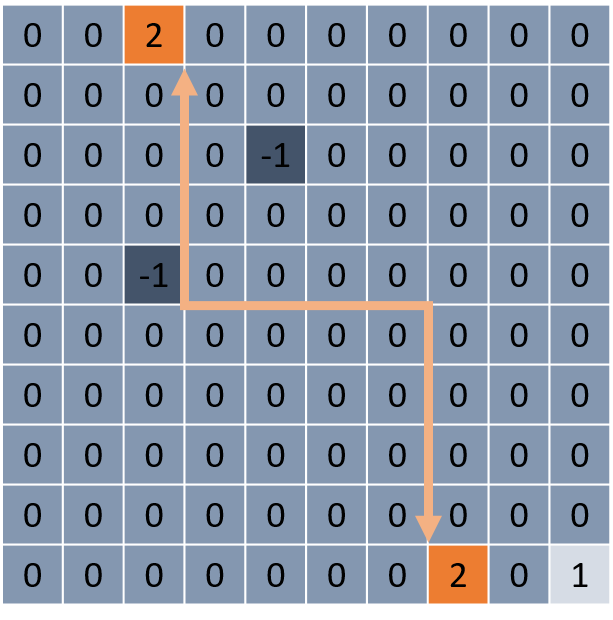

In [3]:
class World:

  def __init__(self, size, terminal, obstacle, hole, catapult):
    # Crea un mundo
    self.size = size
    self.map = {}
    for i in range(size[0]):
      for j in range(size[1]):
        # Estados libres
        self.map[(i, j)] = 0
        # Estados terminales
        for t in terminal:
          if i==t[0] and j==t[1]:
            self.map[(i, j)] = 1
        # Estados con obstáculos
        for o in obstacle:
          if i==o[0] and j==o[1]:
            self.map[(i, j)] = -1
        for h in hole:
          if i==h[0] and j==h[1]:
            self.map[(i, j)] = 2
        for c in catapult:
          if i==c[0] and j==c[1]:
            self.map[(i, j)] = 3

Prueba de la clase *World*:

In [4]:
if __name__ == "__main__":
  w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)], [(2, 2), (7, 7)])
  printMap(w)

[ O  O  T  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  C  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  C  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  T  O  F ]



# Clase *Agent*:

Esta clase controla el agente que aprende por refuerzo en *GridWorld*.

Para crear un agente se necesitan los siguientes datos:

*   *World*: Mundo en el que se desenvuelve el agente.
*   *Initial State*: Estado inicial del agente.

Para controlar el agente se usan los siguientes métodos:

*   *nextState = move(state, action)*: Mueve el agente del estado *state* a un nuevo estado *nextState* aplicando una acción *action*.
*   *reward = reward(nextState)*: Devuelve el refuerzo *reward* que recibe el agente al transicionar al estado *nextState*.
*   *nextState, reward = checkAction(state, action)*: Comprueba a qué estado *nextState* y con qué refuerzo *reward* cambia el agente al aplicar la acción *action* en el estado *state*. Este método no cambia el estado interno del agente, por lo que puede usarse para hacer barridos del espacio de estados.
*   *nextState, reward = executeAction(action)*: Ejecuta la acción *action* en el estado actual y devuelve el nuevo estado *nextState* y el refuerzo *reward*. Este método cambia el estado interno del agente, por lo que sólo debe usarse cuando se realice un recorrido por el mundo.

Nota: Podéis hacer cambios en el agente (distribución de refuerzos, comportamiento en obstáculos...) buscando mejorar el rendimiento de los algoritmos.

In [5]:
class Agent:

  def __init__(self, world, initialState):
    # Crea un agente
    self.world = world
    self.initial_state = np.array(initialState)
    self.state = np.array(initialState)
    
  def reset(self):
    # Resets agent to its initial state
    self.state = np.array(self.initial_state)

  def move(self, state, action):
    # Gestiona las transiciones de estados
    nextState = state + np.array(action)
    if nextState[0] < 0:
      nextState[0] = 0
    elif nextState[0] >= self.world.size[0]:
      nextState[0] = self.world.size[0] - 1
    if nextState[1] < 0:
      nextState[1] = 0
    elif nextState[1] >= self.world.size[1]:
      nextState[1] = self.world.size[1] - 1
    if self.world.map[(nextState[0], nextState[1])] == 2:
      aux = nextState
      for i in range(self.world.size[0]):
        for j in range(self.world.size[1]):
          if self.world.map[(i, j)] == 2 and (nextState[0] != i and nextState[1] != j):
            aux = np.array([i, j])
            nextState = aux
    if self.world.map[(nextState[0], nextState[1])] == 3:
      if action == (1, 0):
        nextState = np.array([np.random.randint(nextState[0], self.world.size[0]-1), nextState[1]])
      elif action == (-1, 0):
        nextState = np.array([np.random.randint(0, nextState[0]), nextState[1]])
      elif action == (0, 1):
        nextState = np.array([nextState[0], np.random.randint(nextState[1], self.world.size[1]-1)])
      elif action == (0, -1):
        nextState = np.array([nextState[0], np.random.randint(0, nextState[1])])
    return nextState

  def reward(self, nextState):
    # Gestiona los refuerzos
    if self.world.map[(nextState[0], nextState[1])] == -1:
      # Refuerzo cuando el agente intenta moverse a un obstáculo
      reward = -1 # ** Prueba varios valores **
    elif self.world.map[(nextState[0], nextState[1])] == 1:
      # Refuerzo cuando el agente se mueve a una celda terminal
      reward = 1 # ** Prueba varios valores **
    else:
      # Refuerzo cuando el agente se mueve a una celda libre
      reward = 0 # ** Prueba varios valores **
    return reward

  def checkAction(self, state, action):
    # Planifica una acción
    nextState = self.move(state, action)
    if self.world.map[(state[0], state[1])] == -1:
      nextState = state
    reward = self.reward(nextState)
    return nextState, reward

  def executeAction(self, action):
    # Planifica y ejecuta una acción
    nextState = self.move(self.state, action)
    if self.world.map[(self.state[0], self.state[1])] == -1:
      nextState = self.state
    else:
      self.state = nextState
    reward = self.reward(nextState)
    return self.state, reward

Prueba de la clase *Agent*:

In [6]:
if __name__ == "__main__":
  # Crear el mundo
  w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)], [(2, 2), (7, 7)])
  printMap(w)
  # Crear el agente
  a = Agent(w, (2, 0))
  # Mover el agente en la diagonal principal
  for i in range(1, 5):
    # Mostrar cada nuevo estado y su recompensa
    print(a.executeAction((0, 1)))

[ O  O  T  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  C  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  C  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  T  O  F ]

(array([2, 1]), 0)
(array([2, 4]), -1)
(array([2, 4]), -1)
(array([2, 4]), -1)


# Trabajo:

En este trabajo vais a implementar los dos algoritmos más comunes de aprendizaje por refuerzo basados en el valor: SARSA y QLearning. Además, vais a probar ambos algoritmos en una serie de escenarios para evaluar su funcionamiento y comparar sus resultados.

## Mundos:

Para probar los algoritmos se ofrecen los siguientes mundos en varios tamaños:

*   Mundo 1: Laberinto fácil que se puede recorrer en zigzag
*   Mundo 2: Mundo con obstáculos aleatorios en el que el teletransporte acorta la distancia desde el inicio hasta el final
*   Mundo 3: Mundo con obstáculos aleatorios en el que el teletransporte no reduce la distancia desde el inicio hasta el final
*   Mundo 4: Mundo con obstáculos aleatorios y catapultas que pueden ser útiles o no para llegar al destino.
*   Mundo 5: Laberinto difícil con caminos correctos y equivocados

Nota: Sentíos libres de utilizar todos o algunos de estos escenarios o directamente crear vuestros propios escenarios.

In [7]:
if __name__ == "__main__":

  # Mundo 1 pequeño: Laberinto fácil
  obstacles = []
  for j in range(0, 4):
    obstacles.append((j, 1))
  for j in range(1, 5):
    obstacles.append((j, 3))
  w1p = World((5, 5), [(4, 4)], obstacles, [], [])
  print("World 1: ")
  printMap(w1p)

  # Mundo 1 mediano: Laberinto fácil
  obstacles = []
  for i in [1, 5]:
    for j in range(0, 8):
      obstacles.append((j, i))
  for i in [3, 7]:
    for j in range(1, 9):
      obstacles.append((j, i))
  w1m = World((9, 9), [(8, 8)], obstacles, [], [])
  print("World 1: ")
  printMap(w1m)

  # Mundo 1 grande: Laberinto fácil
  obstacles = []
  for i in [1, 5, 9, 13, 17]:
    for j in range(0, 20):
      obstacles.append((j, i))
  for i in [3, 7, 11, 15, 19]:
    for j in range(1, 21):
      obstacles.append((j, i))
  w1g = World((21, 21), [(20, 20)], obstacles, [], [])
  print("World 1: ")
  printMap(w1g)

  # Mundo 2 pequeño: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(3):
    obstacles.append((np.random.randint(1, 4), np.random.randint(1, 4)))
  w2p = World((5, 5), [(4, 4)], obstacles, [(2, 0), (4, 2)], [])
  print("World 2: ")
  printMap(w2p)

  # Mundo 2 mediano: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(10):
    obstacles.append((np.random.randint(1, 9), np.random.randint(1, 9)))
  w2m = World((10, 10), [(9, 9)], obstacles, [(3, 1), (8, 6)], [])
  print("World 2: ")
  printMap(w2m)

  # Mundo 2 grande: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(50):
    obstacles.append((np.random.randint(1, 19), np.random.randint(1, 19)))
  w2g = World((21, 21), [(20, 20)], obstacles, [(6, 2), (18, 14)], [])
  print("World 2: ")
  printMap(w2g)

  # Mundo 3 pequeño: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(3):
    obstacles.append((np.random.randint(1, 4), np.random.randint(1, 4)))
  w3p = World((5, 5), [(4, 4)], obstacles, [(4, 0), (0, 4)], [])
  print("World 3: ")
  printMap(w3p)

  # Mundo 3 mediano: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(10):
    obstacles.append((np.random.randint(1, 9), np.random.randint(1, 9)))
  w3m = World((10, 10), [(9, 9)], obstacles, [(8, 1), (1, 8)], [])
  print("World 3: ")
  printMap(w3m)

  # Mundo 3 grande: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(50):
    obstacles.append((np.random.randint(1, 19), np.random.randint(1, 19)))
  w3g = World((21, 21), [(20, 20)], obstacles, [(18, 2), (2, 18)], [])
  print("World 3: ")
  printMap(w3g)

  # Mundo 4 pequeño: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(3):
    obstacles.append((np.random.randint(1, 4), np.random.randint(1, 4)))
  w4p = World((5, 5), [(4, 4)], obstacles, [], [(1, 1)])
  print("World 4: ")
  printMap(w4p)

  # Mundo 4 mediano: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(10):
    obstacles.append((np.random.randint(1, 9), np.random.randint(1, 9)))
  w4m = World((10, 10), [(9, 9)], obstacles, [], [(2, 2), (5, 5)])
  print("World 4: ")
  printMap(w4m)

  # Mundo 4 grande: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(50):
    obstacles.append((np.random.randint(1, 19), np.random.randint(1, 19)))
  w4g = World((21, 21), [(20, 20)], obstacles, [], [(2, 2), (5, 5), (12, 12), (15, 15)])
  print("World 4: ")
  printMap(w4g)

  # Mundo 5: Laberinto difícil
  obstacles = [(0,1),(0,3),(0,9),(0,15),(0,16),(0,17),(0,19),
               (1,1),(1,3),(1,4),(1,5),(1,6),(1,7),(1,9),(1,10),(1,11),(1,12),(1,13),(1,17),(1,19),
               (2,1),(2,9),(2,13),(2,15),(2,16),(2,17),(2,19),
               (3,1),(3,3),(3,5),(3,7),(3,9),(3,11),(3,16),(3,19),
               (4,3),(4,5),(4,7),(4,8),(4,9),(4,10),(4,11),(4,12),(4,13),(4,14),(4,16),(4,18),(4,19),
               (5,0),(5,1),(5,2),(5,3),(5,5),(5,9),(5,16),
               (6,5),(6,6),(6,7),(6,9),(6,10),(6,11),(6,12),(6,13),(6,14),(6,16),(6,17),(6,19),
               (7,0),(7,1),(7,2),(7,3),(7,5),(7,7),(7,9),(7,19),
               (8,3),(8,7),(8,8),(8,9),(8,12),(8,13),(8,14),(8,15),(8,16),(8,17),(8,18),(8,19),
               (9,1),(9,3),(9,5),(9,7),(9,11),(9,12),(9,19),(9,20),
               (10,1),(10,3),(10,5),(10,6),(10,7),(10,9),(10,11),(10,14),(10,15),(10,16),(10,17),
               (11,1),(11,3),(11,5),(11,9),(11,11),(11,13),(11,14),(11,17),(11,18),(11,19),
               (12,1),(12,5),(12,6),(12,8),(12,9),(12,11),(12,13),(12,19),
               (13,1),(13,2),(13,3),(13,4),(13,5),(13,8),(13,15),(13,16),(13,17),(13,19),
               (14,4),(14,7),(14,8),(14,10),(14,12),(14,13),(14,15),(14,19),
               (15,0),(15,1),(15,2),(15,6),(15,7),(15,10),(15,13),(15,14),(15,15),(15,17),(15,18),(15,19),(15,20),
               (16,2),(16,3),(16,5),(16,6),(16,7),(16,8),(16,9),(16,10),(16,11),(16,15),(16,17),
               (17,0),(17,3),(17,5),(17,9),(17,13),(17,14),(17,15),(17,17),(17,19),
               (18,0),(18,1),(18,5),(18,6),(18,7),(18,9),(18,10),(18,11),(18,15),(18,19),
               (19,1),(19,2),(19,4),(19,5),(19,11),(19,13),(19,14),(19,15),(19,16),(19,17),(19,18),(19,19),
               (20,7),(20,8),(20,9),(20,11),(20,19)]
  print("World 5: ")
  w5 = World((21, 21), [(20, 20)], obstacles, [], [])
  printMap(w5)

World 1: 
[ O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

World 1: 
[ O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]

World 1: 
[ O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  

## SARSA:

*SARSA* (State-Action-Reward-State-Action) es un método basado en el valor que permite resolver problemas de aprendizaje por refuerzo. Al igual que el resto de métodos basados en el valor, *SARSA* calcula de forma iterativa la función de valor $Q(S,A)$ y, a partir de ella, determina la política óptima $\pi$.

*SARSA* recibe su nombre de las cinco variables implicadas en su función de actualización: el estado actual ($S_t$), la acción actual ($A_t$), el refuerzo actual ($R_t$), el siguiente estado ($S_{t+1}$) y la siguiente acción ($A_{t+1}$). Esta función de actualización tiene la siguiente forma:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t,A_t)]
\end{equation}

Nota: $\alpha$ es la longitud del episodio y $\gamma$ el factor de descuento.

El algoritmo *SARSA* sigue el siguiente esquema:

1.   Inicializar $Q(S,A)$ para todos los estados y acciones
2.   **Bucle** (repetir $3-9$ hasta la convergencia):
3.   Inicializar $S_t$
4.   Elegir $A_t$ en $S_t$ siguiendo la política derivada de $Q(S,A)$
5.   **Bucle** (repetir $6-9$ hasta que $S_t$ sea terminal):
6.   Tomar la acción $A_t$ en $S_t$ y observar $R_t$ y $S_{t+1}$
7.   Elegir $A_{t+1}$ en $S_{t+1}$ siguiendo la política derivada de $Q(S,A)$
8.   Actualizar el valor $Q(S_t, A_t)$ con la función de actualización
9.   Tomar $S_{t+1}$ y $A_{t+1}$ como los nuevos $S_t$ y $A_t$

El algoritmo *SARSA* utiliza un parámetro $\epsilon \in (0, 1)$ para buscar un equilibrio entre exploración y explotación. A la hora de elegir $A_t$ en $S_t$, si un número aleatorio es menor que $\epsilon$, el algoritmo tomará una acción aleatoria; mientras que si ese número aleatorio es mayor que $\epsilon$, el algoritmo tomará la mejor acción conocida.

## Q-Learning:

*Q-Learning* es el método más conocido para resolver problemas de aprendizaje por refuerzo mediante un esquema basado en el valor. Este algoritmo recibe su nombre directamente de $Q(S,A)$, la función de valor que va actualizando a lo largo de su ejecución. *Q-Learning* es muy parecido a *SARSA*, pero tiene una función de actualización diferente:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma max_a{Q(S_{t+1}}, a) - Q(S_t,A_t)]
\end{equation}

En este caso, la acción $A_{t+1}$ en $S_{t+1}$ se toma buscando el máximo valor, en lugar de poder elegir entre exploración o explotación.

El algoritmo *Q-Learning* sigue el siguiente esquema:

1.   Inicializar $Q(S,A)$ para todos los estados y acciones
2.   **Bucle** (repetir $3-8$ hasta la convergencia):
3.   Inicializar $S_t$
4.   **Bucle** (repetir $6-8$ hasta que $S_t$ sea terminal):
5.   Elegir $A_t$ en $S_t$ siguiendo la política derivada de $Q(S,A)$
6.   Tomar la acción $A_t$ en $S_t$ y observar $R_t$ y $S_{t+1}$
7.   Actualizar el valor $Q(S_t, A_t)$ con la función de actualización
8.   Tomar $S_{t+1}$ como el nuevo $S_t$


## Ejercicio 1:
Implementad los algoritmos SARSA y Q-Learning para el agente y entorno definidos anteriormente

In [8]:
# --- Acciones posibles ---
ACTIONS = [
    (-1, 0),  # Arriba
    (1, 0),   # Abajo
    (0, -1),  # Izquierda
    (0, 1)    # Derecha
]

SEED = 420
INITIAL_STATE = (0, 0)

# --- Funciones Auxiliares ---

class TemporalDifferenceLearner:
    """
    Clase para aprendizaje por diferencia temporal (SARSA o Q-Learning).
    """
    def __init__(self, world, agent_class, actions, config):
        """
        Inicializa el aprendiz TD.

        Args:
            world (World): Entorno grid.
            agent_class (type): Clase del agente.
            actions (list): Lista de tuplas de coordenadas de acciones.
            config (dict): Hiperparámetros y configuraciones.
        """
        self.world = world
        self.actions = actions
        self.num_actions = len(actions)
        self._validate_and_set_config(config)

        self.agent = agent_class(world, self.config['initial_state'])
        self.q_table = np.zeros((*self.world.size, self.num_actions), dtype=float)
        self.rng = np.random.default_rng(self.config['seed'])

        # Variables de seguimiento
        self.episode_rewards = []
        self.episode_steps = []
        self.best_q_table = None
        self.best_path_length = float('inf')
        self.converged_episode = -1
        self.total_episodes_run = 0
        self.current_epsilon = self.config['initial_epsilon']

    def _validate_and_set_config(self, config):
        """Establece y valida los valores de configuración por defecto."""
        defaults = {
            'learning_rate': 0.1,         # Tasa de aprendizaje (alpha)
            'discount_factor': 0.99,      # Factor de descuento (gamma)
            'initial_epsilon': 0.2,       # Tasa inicial de exploración
            'epsilon_decay': 0.995,       # Factor de decaimiento de epsilon
            'min_epsilon': 0.01,          # Valor mínimo de epsilon
            'epsilon_decay_interval': 50, # Intervalo (en episodios) para decaer epsilon
            'num_episodes': 1000,         # Número total de episodios
            'max_steps_per_episode': self.world.size[0] * self.world.size[1] * 2,  # Límite de pasos
            'seed': SEED,                 # Semilla aleatoria
            'update_rule': 'q_learning',  # 'q_learning' o 'sarsa'
            'verbose': False,             # Mostrar progreso y políticas
            'eval_interval': 50,          # Intervalo de evaluación en episodios
            'initial_state': INITIAL_STATE  # Posición inicial del agente
        }
        defaults.update(config)
        self.config = defaults
        if self.config['update_rule'] not in ['q_learning', 'sarsa']:
            raise ValueError("config['update_rule'] debe ser 'q_learning' o 'sarsa'")
        print(f"Configuración del aprendiz: {self.config}")

    def _select_action(self, state_tuple):
        """Selecciona una acción con estrategia epsilon-greedy."""
        if self.world.map[state_tuple] in [1, -1]:
            return -1  # Estado terminal u obstáculo

        if self.rng.random() < self.current_epsilon:
            return self.rng.choice(self.num_actions)  # Explorar
        else:
            q_values = self.q_table[state_tuple[0], state_tuple[1], :]
            max_q = np.max(q_values)
            best_action_indices = np.where(np.isclose(q_values, max_q))[0]
            if not len(best_action_indices):
                return self.rng.choice(self.num_actions)
            return self.rng.choice(best_action_indices)

    def _apply_update(self, state_tuple, action_index, reward, next_state_tuple, next_action_index):
        """
        Aplica la actualización TD (SARSA o Q-Learning) a la Q-table.
        """
        current_q = self.q_table[state_tuple[0], state_tuple[1], action_index]
        alpha = self.config['learning_rate']
        gamma = self.config['discount_factor']
        target_q_next = 0.0  # Valor Q por defecto para estados terminales u obstáculos

        is_next_terminal = (self.world.map.get(next_state_tuple, 0) in [1, -1])
        if not is_next_terminal:
            if self.config['update_rule'] == 'sarsa':
                if next_action_index != -1:
                    target_q_next = self.q_table[next_state_tuple[0], next_state_tuple[1], next_action_index]
            elif self.config['update_rule'] == 'q_learning':
                target_q_next = np.max(self.q_table[next_state_tuple[0], next_state_tuple[1], :])

        td_target = reward + gamma * target_q_next
        td_error = td_target - current_q
        self.q_table[state_tuple[0], state_tuple[1], action_index] = current_q + alpha * td_error

    def run_single_episode(self, episode_num):
        """Ejecuta un episodio del algoritmo de aprendizaje."""
        self.agent.reset()
        state_tuple = tuple(self.agent.state)
        action_index = self._select_action(state_tuple)

        if action_index == -1:
            return 0, 0

        accumulated_reward = 0.0
        steps_taken = 0

        while steps_taken < self.config['max_steps_per_episode']:
            current_state_tuple = tuple(self.agent.state)
            if self.world.map[current_state_tuple] in [1, -1]:
                break

            action_coords = self.actions[action_index]
            next_state_array, reward = self.agent.checkAction(np.array(current_state_tuple), action_coords)
            next_state_tuple = tuple(next_state_array)
            accumulated_reward += reward

            next_action_index = self._select_action(next_state_tuple)
            self._apply_update(current_state_tuple, action_index, reward, next_state_tuple, next_action_index)

            # Actualiza el estado del agente
            self.agent.state = next_state_array

            action_index = next_action_index
            steps_taken += 1

            if action_index == -1:
                break

        if (episode_num + 1) % self.config['epsilon_decay_interval'] == 0 and self.current_epsilon > self.config['min_epsilon']:
            self.current_epsilon *= self.config['epsilon_decay']
            self.current_epsilon = max(self.config['min_epsilon'], self.current_epsilon)

        return accumulated_reward, steps_taken

    def train(self):
        """Realiza el ciclo principal de entrenamiento."""
        print(f"\n--- Iniciando Entrenamiento ({self.config['update_rule']}) ---")
        self.current_epsilon = self.config['initial_epsilon']
        start_time = time.time()
        found_goal_policy = False

        for episode in range(self.config['num_episodes']):
            self.total_episodes_run = episode + 1
            reward, steps = self.run_single_episode(episode)
            self.episode_rewards.append(reward)
            self.episode_steps.append(steps)

            if (episode + 1) % self.config['eval_interval'] == 0 or episode == self.config['num_episodes'] - 1:
                avg_reward_recent = np.mean(self.episode_rewards[-(self.config['eval_interval']):])
                print(f"Ep: {episode + 1}/{self.config['num_episodes']} | "
                      f"Pasos: {steps} | Recompensa: {reward:.2f} | "
                      f"Promedio (últimos {self.config['eval_interval']}): {avg_reward_recent:.2f} | "
                      f"Epsilon: {self.current_epsilon:.4f}")

                current_policy = self.get_policy()
                reached_goal, path_len, eval_reward = self.evaluate_policy(current_policy)

                if self.config['verbose']:
                    print("Política actual:")
                    printPolicy(self.world, current_policy)

                if reached_goal:
                    found_goal_policy = True
                    print(f"Evaluación: ¡Meta alcanzada! Longitud del camino: {path_len}, Recompensa: {eval_reward:.2f}")
                    if path_len != -1 and path_len < self.best_path_length:
                        print(f"*** Nueva mejor política encontrada (Longitud: {path_len}) ***")
                        self.best_path_length = path_len
                        self.best_q_table = self.q_table.copy()
                        self.converged_episode = episode + 1
                else:
                    print("Evaluación: Meta no alcanzada.")

        end_time = time.time()
        print(f"\n--- Entrenamiento finalizado en {end_time - start_time:.2f} segundos ---")

        if self.best_q_table is not None:
            print(f"La mejor política (episodio {self.converged_episode}) tiene longitud: {self.best_path_length}")
            self.q_table = self.best_q_table
            return True, self.converged_episode, self.best_path_length
        elif found_goal_policy:
            print("Se encontró una política que alcanza la meta, pero sin mejoras registradas. Usando la Q-table final.")
            final_policy = self.get_policy()
            reached_goal, path_len, _ = self.evaluate_policy(final_policy)
            if reached_goal:
                print(f"La política final alcanza la meta con longitud {path_len}.")
                return True, self.total_episodes_run, path_len
            else:
                print("La política final no alcanza la meta.")
                return False, self.total_episodes_run, -1
        else:
            print("No se encontró ninguna política que alcance la meta durante el entrenamiento.")
            return False, self.total_episodes_run, -1

    def get_policy(self):
        """Extrae la política greedy de la Q-table actual."""
        policy_grid = np.full(self.world.size, -1, dtype=int)
        rows, cols = self.world.size

        for r in range(rows):
            for c in range(cols):
                state_tuple = (r, c)
                if self.world.map.get(state_tuple, 0) not in [1, -1]:
                    policy_grid[r, c] = np.argmax(self.q_table[r, c, :])

        return policy_grid

    def evaluate_policy(self, policy_grid):
        """
        Evalúa la política ejecutando al agente en el entorno.

        Args:
            policy_grid (np.ndarray): Matriz con el índice de acción para cada estado.

        Returns:
            tuple: (meta_alcanzada (bool), longitud_camino (int), recompensa_acumulada (float))
                   La longitud del camino es -1 si la meta no se alcanza.
        """
        eval_agent = self.agent.__class__(self.world, self.config['initial_state'])
        eval_agent.reset()
        state_tuple = tuple(eval_agent.state)
        accumulated_reward = 0.0
        path_length = 0
        max_eval_steps = self.world.size[0] * self.world.size[1] * 2

        for step in range(max_eval_steps):
            if self.world.map[state_tuple] == 1:
                return True, path_length, accumulated_reward
            if self.world.map[state_tuple] == -1:
                return False, -1, accumulated_reward

            action_index = policy_grid[state_tuple[0], state_tuple[1]]
            if action_index == -1:
                return False, -1, accumulated_reward

            action_coords = self.actions[action_index]
            next_state_array, reward = eval_agent.checkAction(np.array(state_tuple), action_coords)
            eval_agent.state = next_state_array
            state_tuple = tuple(eval_agent.state)
            accumulated_reward += reward
            path_length += 1

        return False, -1, accumulated_reward


In [9]:
def run_sarsa_new(world, agent_class, actions, config_override={}):
    """Helper function to run SARSA using the TemporalDifferenceLearner."""
    config = {
        'update_rule': 'sarsa',
        'initial_state': INITIAL_STATE, # Ensure it uses the global default or override
        'seed': SEED
    }
    config.update(config_override) # Apply any user overrides
    learner = TemporalDifferenceLearner(world, agent_class, actions, config)
    learner.train()
    policy = learner.get_policy()
    return policy, learner

In [10]:
def run_q_learning_new(world, agent_class, actions, config_override={}):
    """Helper function to run Q-Learning using the TemporalDifferenceLearner."""
    config = {
        'update_rule': 'q_learning',
        'initial_state': INITIAL_STATE, # Ensure it uses the global default or override
        'seed': SEED
    }
    config.update(config_override) # Apply any user overrides
    learner = TemporalDifferenceLearner(world, agent_class, actions, config)
    learner.train()
    policy = learner.get_policy()
    return policy, learner

[ O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]


Selected World: Map shown above.
Agent Initial State: (0, 0)
------------------------------

RUNNING NEW SARSA IMPLEMENTATION
Configuración del aprendiz: {'learning_rate': 0.15, 'discount_factor': 0.98, 'initial_epsilon': 0.3, 'epsilon_decay': 0.997, 'min_epsilon': 0.02, 'epsilon_decay_interval': 20, 'num_episodes': 4000, 'max_steps_per_episode': 243, 'seed': 420, 'update_rule': 'q_learning', 'verbose': False, 'eval_interval': 100, 'initial_state': (0, 0)}

--- Iniciando Entrenamiento (q_learning) ---
Ep: 100/4000 | Pasos: 13 | Recompensa: -1.00 | Promedio (últimos 100): -1.00 | Epsilon: 0.2955
Evaluación: Meta no alcanzada.
Ep: 200/4000 | Pasos: 19 | Recompensa: -1.00 | Promedio (últimos 100): -1.00 | Epsilon: 0.2911
Evaluación: Meta

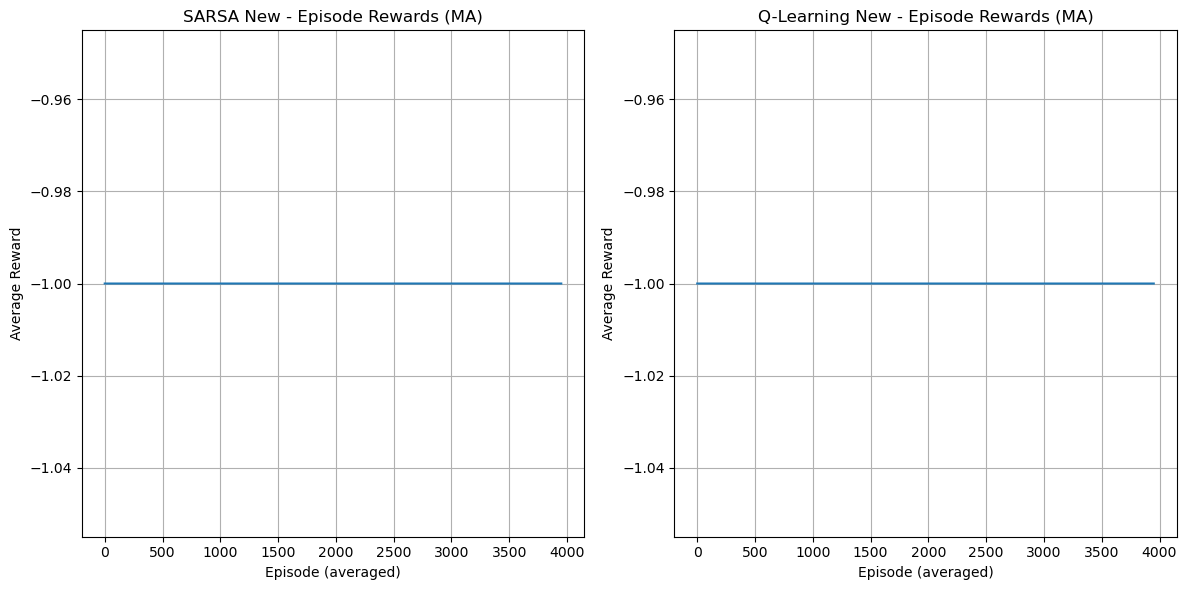

In [13]:
if __name__ == "__main__":
    

    # --- Select World and Agent ---
    
    # current_world = w1p
    current_world = w1m
    # current_world = w1g
    # current_world = w2p
    # current_world = w2m
    # current_world = w2g
    # current_world = w3p
    # current_world = w3m
    # current_world = w3g
    # current_world = w4p
    # current_world = w4m
    # current_world = w4g
    # current_world = w5
    initial_agent_state = (0, 0) # Common starting point
    agent = Agent(current_world, initial_agent_state)
    
    printMap(current_world)

    print(f"\nSelected World: Map shown above.")
    print(f"Agent Initial State: {initial_agent_state}")
    print("-" * 30)
    
    common_config = {
            'learning_rate': 0.15,         # Tasa de aprendizaje (alpha)
            'discount_factor': 0.98,      # Factor de descuento (gamma)
            'initial_epsilon': 0.3,       # Tasa inicial de exploración
            'epsilon_decay': 0.997,       # Factor de decaimiento de epsilon
            'min_epsilon': 0.02,          # Valor mínimo de epsilon
            'epsilon_decay_interval': 20, # Intervalo (en episodios) para decaer epsilon
            'num_episodes': 4000,         # Número total de episodios
            'max_steps_per_episode': current_world.size[0] * current_world.size[1] * 3,  # Límite de pasos
            'seed': SEED,                 # Semilla aleatoria
            'update_rule': 'q_learning',  # 'q_learning' o 'sarsa'
            'verbose': False,             # Mostrar progreso y políticas
            'eval_interval': 100,         # Intervalo de evaluación en episodios
            'initial_state': INITIAL_STATE  # Posición inicial del agente
        }

    # --- SARSA ---
    print("\n" + "="*40)
    print("RUNNING NEW SARSA IMPLEMENTATION")
    print("="*40)
    sarsa_policy_new, sarsa_learner = run_sarsa_new(
        current_world,
        Agent,
        ACTIONS,
        common_config.copy()
    )
    print("\nSARSA Final Policy:")
    printPolicy(current_world, sarsa_policy_new)
    if sarsa_learner.best_path_length != float('inf'):
        print(f"SARSA Best Path Length Found: {sarsa_learner.best_path_length}")
    else:
        print("SARSA did not definitively converge to a goal policy.")


    # --- Q-Learning ---
    print("\n" + "="*40)
    print("RUNNING NEW Q-LEARNING IMPLEMENTATION")
    print("="*40)
    qlearning_policy_new, qlearning_learner = run_q_learning_new(
        current_world,
        Agent,
        ACTIONS,
        common_config.copy()
    )
    print("\nQ-Learning Final Policy:")
    printPolicy(current_world, qlearning_policy_new)
    if qlearning_learner.best_path_length != float('inf'):
        print(f"Q-Learning Best Path Length Found: {qlearning_learner.best_path_length}")
    else:
        print("Q-Learning did not definitively converge to a goal policy.")


    # --- Mostrar Mapas ---
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 6))

        def moving_average(data, window_size=50):
            if len(data) < window_size: return data
            return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

        plt.subplot(1, 2, 1)
        plt.plot(moving_average(sarsa_learner.episode_rewards))
        plt.title(f"SARSA New - Episode Rewards (MA)")
        plt.xlabel("Episode (averaged)")
        plt.ylabel("Average Reward")
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(moving_average(qlearning_learner.episode_rewards))
        plt.title(f"Q-Learning New - Episode Rewards (MA)")
        plt.xlabel("Episode (averaged)")
        plt.ylabel("Average Reward")
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    except ImportError:
        print("\nMatplotlib not found. Skipping reward plot.")
    except Exception as e:
        print(f"\nError plotting rewards: {e}")

## Análisis:

*SARSA* y *Q-Learning* son dos algoritmos muy parecidos, que se pueden aplicar en los mismos problemas y suelen encontrar soluciones similares. No obstante, los resultados de ambos algoritmos pueden diferir en ciertos problemas: por ejemplo, hay un problema llamado Cliffworld en el que SARSA encuentra soluciones más seguras y con menos valor, mientras que Q-Learning asume más riesgos y consigue más valor ([artículo interesante](https://medium.com/gradientcrescent/fundamentals-of-reinforcement-learning-navigating-cliffworld-with-sarsa-and-q-learning-cc3c36eb5830)).

## Ejercicio 2:

Analizad los resultados obtenidos por ambos algoritmos en los escenarios de prueba. Algunos posibles análisis se muestran a continuación, no es necesario que hagáis todos.

1.   Comentad el rendimiento que observáis en ambos algoritmos. ¿Qué problemas son capaces de resolver? ¿En cuáles no encuentran la solución óptima? ¿A qué se puede deber este comportamiento?

2.   Comentad las diferencias entre los algoritmos en los diferentes escenarios: ¿Cuál resuelve más escenarios? ¿Cuál converge más rápido? ¿Cuál genera más valor? ¿Hay diferencias en la gestión de riesgos en los agujeros de gusano y las catapultas?

3.   Comentad las diferencias cuando se aplica una mayor exploración ($\epsilon$ más alto) y una mayor explotación ($\epsilon$ más bajo). ¿Cuál converge más rápido? ¿Cuál obtiene más valor? ¿Qué estrategia piensas que podría usarse para explorar y explotar de forma más inteligente?

Nota: Las siguientes variables pueden ser interesantes para valorar los resultados: Diferencia entre la política resultante y la política óptima, número de iteraciones necesarias para converger, retorno total del problema y retorno obtenido en cada episodio.

In [ ]:
# Resolución: Código necesario para generar y comparar los resultados

Resolución: Comentarios sobre los resultados


## Ejercicio 3:

Imaginad que queremos desarrollar un agente "estúpido" que caiga en los obstáculos más cercanos en lugar de evitarlos para alcanzar el objetivo. Para ello sólo tenemos que cambiar el sistema de refuerzos que recibe el agente al realizar acciones en los estados. Nuestros algoritmos de SARSA y Q-Learning deberían hacer el resto sin necesidad de modificaciones.

1. Programad una función de refuerzo para la clase agente modificada que se muestra en el siguiente bloque de código que permita entrenar al agente "estúpido".

2. Aplicad SARSA y QLearning al nuevo agente "estúpido" en algunos de los laberintos generados previamente. Sugerencia: para una mejor exploración, en lugar de iniciar los episodios en el origen, iniciarlos en estados aleatorios. ¿Cuál es su comportamiento? ¿Alcanza el objetivo? ¿Consigue caer en todos los obstáculos?




In [ ]:
class StupidAgent:

  def __init__(self, world, initialState):
    # Crea un agente
    self.world = world
    self.state = np.array(initialState)

  def move(self, state, action):
    # Gestiona las transiciones de estados
    nextState = state + np.array(action)
    if nextState[0] < 0:
      nextState[0] = 0
    elif nextState[0] >= self.world.size[0]:
      nextState[0] = self.world.size[0] - 1
    if nextState[1] < 0:
      nextState[1] = 0
    elif nextState[1] >= self.world.size[1]:
      nextState[1] = self.world.size[1] - 1
    if self.world.map[(nextState[0], nextState[1])] == 2:
      aux = nextState
      for i in range(self.world.size[0]):
        for j in range(self.world.size[1]):
          if self.world.map[(i, j)] == 2 and (nextState[0] != i and nextState[1] != j):
            aux = np.array([i, j])
            nextState = aux
    if self.world.map[(nextState[0], nextState[1])] == 3:
      if action == (1, 0):
        nextState = np.array([np.random.randint(nextState[0], self.world.size[0]-1), nextState[1]])
      elif action == (-1, 0):
        nextState = np.array([np.random.randint(0, nextState[0]), nextState[1]])
      elif action == (0, 1):
        nextState = np.array([nextState[0], np.random.randint(nextState[1], self.world.size[1]-1)])
      elif action == (0, -1):
        nextState = np.array([nextState[0], np.random.randint(0, nextState[1])])
    return nextState

  def reward(self, nextState):
    # Gestiona los refuerzos
    reward = 0
    # EDITAR LA FUNCION
    return reward

  def checkAction(self, state, action):
    # Planifica una acción
    nextState = self.move(state, action)
    if self.world.map[(state[0], state[1])] == -1:
      nextState = state
    reward = self.reward(nextState)
    return nextState, reward

  def executeAction(self, action):
    # Planifica y ejecuta una acción
    nextState = self.move(self.state, action)
    if self.world.map[(self.state[0], self.state[1])] == -1:
      nextState = self.state
    else:
      self.state = nextState
    reward = self.reward(nextState)
    return self.state, reward

In [ ]:
# Resolución: Código necesario para generar y comparar los resultados

Resolución: Comentarios sobre los resultados

Nota: Sentíos libres de añadir los bloques de código y texto necesarios para responder las preguntas.